<div style="text-align: center; font-size: 25pt; font-weight: bold; margin: 1em 0em 1em 0em">Usages of the MCN package</div>

**Author:** Adel Nabli

# Introduction: The Multilevel Critical Node problem

We have a graph $G(V,E)$ and we want to solve a multilevel critical node problem as introduced in [1]. We use the following variables:
* $D \subset V$: set of vaccinated nodes $\quad ; \quad$ $z_v = \mathbb{1}_{\text{v is vaccinated}}$ $\quad ; \quad$ $\sum_{v \in V} z_v \leq \Omega$
* $P \subset V$: set of protected nodes $\quad ; \quad$ $x_v = \mathbb{1}_{\text{v is protected}}$ $\quad ; \quad$ $\sum_{v \in V} x_v \leq \Lambda$
* $I \subset V$: set of attacked nodes $\quad ; \quad$ $y_v = \mathbb{1}_{\text{v is attacked}}$ $\quad ; \quad$ $\sum_{v \in V} y_v \leq \Phi$
* $S \subset V$: set of saved nodes $\quad ; \quad$ $\alpha_v = \mathbb{1}_{\text{v is saved}}$

We want to solve the following trilevel problem:
<h3 align="center"> $ \underset{ \substack{z \in \{0,1\}^V \\ \sum_{v \in V} z_v \leq \Omega}}{\max} \underset{ \substack{y \in \{0,1\}^V \\ \sum_{v \in V} y_v \leq \Phi}}{\min} \underset{ \substack{x \in \{0,1\}^V \\ \alpha \in [0,1]^V}}{\max} \sum_{v \in V} \alpha_v  \\ \quad \quad  \quad \quad \text{subject to} \quad \sum_{v \in V} x_v \leq \Lambda \\ \quad  \quad \quad  \quad \quad \quad \quad \quad \quad \alpha_v \leq 1+ z_v - y_v \quad \forall v \in V \\ \quad  \quad \quad  \quad \quad \quad \quad \quad \quad \alpha_v \leq \alpha_u + x_v + z_v \quad \forall (u,v) \in E$</h3>

**Sources:**

[1] **A. Baggio, M. Carvalho, A. Lodi, A. Tramontani**, ["Multilevel Approaches for the Critical Node Problem"]( http://cerc-datascience.polymtl.ca/wp-content/uploads/2017/11/Technical-Report_DS4DM-2017-012.pdf), 2018.

# [OPTIONAL] Google colab: installing packages

If this notebook is to be run on google colab, some extra steps should be taken to properly install pytorch geometric.
Replace ```${CUDA}``` with the version used on your PyTorch installation as explained in the [pytorch geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html)

In [ ]:
!pip install torch-scatter==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-sparse==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-cluster==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-spline-conv==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-geometric
!pip install --upgrade git+https://github.com/AdelNabli/MCN

# 1. Training the neural network to solve the MCN

In [1]:
# Import the training function
from MCN.MCN_curriculum.train import train_value_net

L:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### a) setting the variables governing the distribution of instances

In [1]:
# n_free designs the number of nodes of the graph
# that would be neither vaccinated, infected or attacked.
# It governs the range of graph's sizes we are considering
n_free_min = 9
n_free_max = 14
# d_edge controls the density of edge we want the instances
# to have. d_edge = 1. means that all possible edges are created
# i.e, we have a clique
d_edge_min = 0.2
d_edge_max = 0.5
# Omega, Phi and Lambda are the budgets of the players
# Phi_max should be >= 1, otherwise there is no MCN problem
Omega_max = 3
Phi_max = 3
Lambda_max = 3
w_max = 5
weighted = False
directed = False

In [2]:
from MCN.MCN_curriculum.data import generate_test_set

L:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
weighted = True
directed = False
generate_test_set(n_free_min, n_free_max, d_edge_min, d_edge_max, Omega_max, Phi_max, Lambda_max,
                  weighted, w_max, directed, size_test_set=1000, to_torch=True)

Generates the test set... 



100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [2:46:26<00:00, 1879.48s/it]


In [4]:
weighted = False
directed = True
generate_test_set(n_free_min, n_free_max, d_edge_min, d_edge_max, Omega_max, Phi_max, Lambda_max,
                  weighted, w_max, directed, size_test_set=1000, to_torch=True)

Generates the test set... 



100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [2:01:14<00:00, 1535.54s/it]


In [5]:
weighted = False
directed = False
generate_test_set(n_free_min, n_free_max, d_edge_min, d_edge_max, Omega_max, Phi_max, Lambda_max,
                  weighted, w_max, directed, size_test_set=1000, to_torch=True)

Generates the test set... 



100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [2:18:56<00:00, 1720.46s/it]


In [10]:
generate_test_set(n_free_min, n_free_max, d_edge_min, d_edge_max, Omega_max, Phi_max, Lambda_max,
                  weighted, w_max, directed, size_test_set=500, to_torch=True)

Generates the test set... 



100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:17:43<00:00, 891.41s/it]


### b) setting the hyperparameters of the neural network

In [2]:
# h1 and h2 are the hidden dim sizes used throughout
# the neural net's architecture.
h1 = 256
h2 = 128
# the number of attention heads in the GAT
n_heads = 4
# the 'skip connection' parameter in the APPNP part
alpha = 0.1
# the dropout probability
p = 0.2

### c) setting the parameters of the training algorithm

In [3]:
# batch size used
batch_size = 256
# Size of training set
size_train_data = 100000
# Size of the validation set
size_val_data = 500
# Learning rate of the optimizer
lr = 1e-4
# betas parameters of the optimizer
betas = (0.8,0.9)
# number of epoch
n_epoch = 60
# path to the directory to pre-trained target nets
path_experts = None #"models/colab/experts"
# path to the directory containing the training and validation data
path_data = 'data'
# If resume training, set to True
resume_training = False
# path to the file containing the training parameters to load
path_train = "" #"models/value_net.tar"

In [ ]:
# Train the neural network
train_value_net(batch_size, size_train_data, size_val_data, lr, betas, n_epoch, h1, h2, n_heads, alpha, p,
                n_free_min, n_free_max, d_edge_min, d_edge_max, Omega_max, Phi_max, Lambda_max,
                num_workers=0, path_experts=path_experts, path_data=path_data, resume_training=resume_training,
                path_train=path_train)

# 2. Using trained experts or an exact algorithm to solve an instance of MCN

### a) Generating a random instance

In [6]:
# import the function generating a random instance
from MCN.utils import generate_random_instance, plot_graph

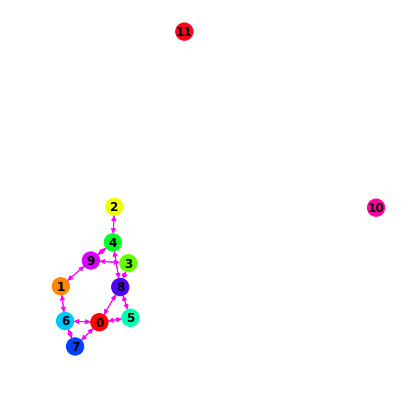

Already attacked nodes :  []
Omega : 0 ,  Phi : 1 , Lambda : 2


In [39]:
instance = generate_random_instance(n_free_min, n_free_max, d_edge_min, d_edge_max, Omega_max, Phi_max, Lambda_max)
G = instance.G
Omega = instance.Omega
Phi = instance.Phi
Lambda = instance.Lambda
J = instance.J
# plots the graph
plot_graph(G)
# print the other parameters
print("Already attacked nodes : ", J)
print("Omega : %d ,  Phi : %d , Lambda : %d"%(Omega, Phi, Lambda))

### b) Solving the instance exactly

In [2]:
# import the solver
from MCN.solve_mcn import solve_mcn

L:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
value, D, I, P = solve_mcn(G, Omega, Phi, Lambda, J=J, exact=True)
# print the outputs
print("number of saved nodes : ", value + Omega + Lambda)
print("Vaccinated nodes D: ", D)
print("Attacked nodes I : ", I)
print("Protected nodes P :", P)

number of saved nodes :  7
Vaccinated nodes D:  [6, 9]
Attacked nodes I :  [0, 5]
Protected nodes P : [3, 11]


### c) Solving the instance heuristically with pre-trained experts

In [6]:
# import the ValueNet object
from MCN.MCN_curriculum.value_nn import ValueNet
# import the experts loader
from MCN.utils import load_saved_experts

In [7]:
# load the models
list_experts = load_saved_experts("models/experts")

L:\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
L:\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
L:\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_

In [15]:
value, D, I, P = solve_mcn(G, Omega, Phi, Lambda, J=J,
                           Omega_max=Omega_max, Phi_max=Phi_max, Lambda_max=Lambda_max,
                           exact=False, list_experts=list_experts)
# print the outputs
# the expert nets outputs values that don't contain nodes bound to be saved
# so we add the defender's budget back to the value
print("number of saved nodes : ", value + Omega + Lambda)
print("Vaccinated nodes D: ", D)
print("Attacked nodes I : ", I)
print("Protected nodes P :", P)

number of saved nodes :  7.0
Vaccinated nodes D:  [11, 6]
Attacked nodes I :  [0, 13]
Protected nodes P : [10, 3]


# 3. Test the performances of the heuristic

### a) Generate a test set

In [11]:
# import the generator
from MCN.MCN_curriculum.data import generate_test_set

In [13]:
# create a test set named "test_set.gz" in the directory given (creates it if not existing)
generate_test_set(n_free_min, n_free_max, d_edge_min, d_edge_max, Omega_max, Phi_max, Lambda_max,
                  size_test_set=6000)

Generates the test set... 



100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [23:15<00:00, 305.58s/it]


### b) Compute the optimality gap of the heuristic

Formula applied to compute the optimality gap:
<h3 align="center"> $ \dfrac{1}{n_{instance}} \sum_{i=1}^{n_{instance}}\dfrac{|value_i^{(true)} - value_i^{(heur)}|}{ value_i^{(true)}}$</h3>

In [3]:
# import the fonction that tests that
from MCN.test_performances.optimality_gap import compute_optimality_gap

In [8]:
og_budget, og_player = compute_optimality_gap(Omega_max, Phi_max, Lambda_max,
                                              list_experts=list_experts, path_test_set="data/test_data/test_set.gz")

Computing the values using the heuristic... 



100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [20:01<00:00, 245.40s/it]


In [9]:
for k in range(Omega_max + Phi_max + Lambda_max):
    budget = k + 1
    if budget <= Lambda_max:
        print("optimality gap for instances with budget Omega = 0, Phi = 0 , Lambda = %d : %f %%"%(budget, og_budget[k]*100))
    elif budget <= Lambda_max + Phi_max:
        print("optimality gap for instances with budget Omega = 0, Phi = %d , Lambda \in [0, %d] : %f %%"%(budget - Lambda_max, Lambda_max, og_budget[k]*100))
    elif budget > Lambda_max + Phi_max:
        print("optimality gap for instances with budget Omega = %d, Phi \in [1, %d] , Lambda \in [0, %d] : %f %%"%(budget - Lambda_max - Phi_max, Phi_max, Lambda_max, og_budget[k]*100))

optimality gap for instances with budget Omega = 0, Phi = 0 , Lambda = 1 : 0.000000 %
optimality gap for instances with budget Omega = 0, Phi = 0 , Lambda = 2 : 0.000000 %
optimality gap for instances with budget Omega = 0, Phi = 1 , Lambda \in [0, 2] : 0.066667 %
optimality gap for instances with budget Omega = 0, Phi = 2 , Lambda \in [0, 2] : 0.172619 %
optimality gap for instances with budget Omega = 1, Phi \in [1, 2] , Lambda \in [0, 2] : 0.312150 %
optimality gap for instances with budget Omega = 2, Phi \in [1, 2] , Lambda \in [0, 2] : 0.568019 %


In [10]:
print("optimality gap for the vaccinator : %f %%" % (og_player[0]*100))
print("optimality gap for the attacker : %f %%" % (og_player[1]*100))
print("optimality gap for the protector : %f %%" % (og_player[2]*100))

optimality gap for the vaccinator : 0.440085 %
optimality gap for the attacker : 0.119643 %
optimality gap for the protector : 0.000000 %
